This is the code for Decision-Making for Autonomous Vehicle Overtaking using Dueling Double DQN.

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys

user = 'saurabh'
# user = 'aditya'

# define path to code 
if user == "saurabh":
  path = '/content/drive/MyDrive/ENPM690/Final_project'
  print("using saurabh's path")
else:
  path = '/content/drive/MyDrive/Final_project'
  print("using aditya's path")

using saurabh's path


# Installing Dependecies to Render OpenAI Gym Environment and Virtual Display

In [ ]:
!apt-get update
!pip install pyglet
!pip install gym pyvirtualdisplay
!pip install xvfbwrapper
!apt-get install -y xvfb python-opengl ffmpeg
! pip3 install highway-env
# install necessary packages to get virtual display in colab
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# !pip install colabgymrender==1.0.2
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
import gymnasium as gym
from collections import deque
import tensorflow as tf
import numpy as np
import random
import math
import time
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
import os
import csv


Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:9 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,681 kB]
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,046 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,343 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/main a

# Configure the highway environment

In [ ]:
configr = {
  "normalize_reward" : False,
  "collision_reward": -1,    # The reward received when colliding with a vehicle.
  "right_lane_reward": 0,    # The reward received when driving on the right-most lanes, linearly mapped to zero for other lanes.
  "high_speed_reward": 0.4,  # The reward received when driving at full speed, linearly mapped to zero for lower speeds according to config["reward_speed_range"].
  "lane_change_reward": 1,   # The reward received at each lane change action.
  "reward_speed_range": [25, 35],
  "ego_spacing": 1
}

In [ ]:
# Load gym environment and get action and state spaces.
import highway_env
env = gym.make('highway-v0')
env.configure(configr)
num_features = env.observation_space.shape[0]
num_actions = env.action_space.n
print('Number of state features: {}'.format(num_features))
print('Number of possible actions: {}'.format(num_actions))

Number of state features: 5
Number of possible actions: 5


/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


# Dueling Double DQN model

In [ ]:
class DDDQN(tf.keras.Model):
  """Dense neural network class."""
  def __init__(self):
    super(DDDQN, self).__init__()
    self.dense1 = tf.keras.layers.Dense(32, activation="relu")
    self.fl1 = tf.keras.layers.Flatten() 
    self.dense2 = tf.keras.layers.Dense(64, activation="relu")
    self.dense3 = tf.keras.layers.Dense(64, activation="relu")
    self.dense4 = tf.keras.layers.Dense(128, activation="relu")
    self.V_Stream = tf.keras.layers.Dense(64, activation='relu')
    self.V = tf.keras.layers.Dense(1, activation=None)
    self.A_Stream = tf.keras.layers.Dense(64, activation='relu')
    self.A = tf.keras.layers.Dense(num_actions, activation=None)
    
    # Combine Value and Advantage Streams
    self.mean_A = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1, keepdims=True))
    
  def call(self, x):
    """Forward pass."""
    x = self.dense1(x)
    x = self.fl1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    x = self.dense4(x)
    value_str = self.V_Stream(x)
    value = self.V(value_str)
    adv_str = self.A_Stream(x)
    adv = self.A(adv_str)
    mean_adv = self.mean_A(adv)
    centered_A = tf.keras.layers.Subtract()([adv, mean_adv])
    Q = tf.keras.layers.Add()([value, centered_A])

    return Q

main_nn = DDDQN()
target_nn = DDDQN()

optimizer = tf.keras.optimizers.Adam(1e-4)
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
class ReplayBuffer(object):
  """Experience replay buffer that samples uniformly."""
  def __init__(self, size):
    self.buffer = deque(maxlen=size)

  def add(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))

  def __len__(self):
    return len(self.buffer)

  def sample(self, num_samples):
    states, actions, rewards, next_states, dones = [], [], [], [], []
    idx = np.random.choice(len(self.buffer), num_samples)
    for i in idx:
      elem = self.buffer[i]
      state, action, reward, next_state, done = elem
      states.append(np.array(state, copy=False))
      actions.append(np.array(action, copy=False))
      rewards.append(reward)
      next_states.append(np.array(next_state, copy=False))
      dones.append(done)
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards, dtype=np.float32)
    next_states = np.array(next_states)
    dones = np.array(dones, dtype=np.float32)
    return states, actions, rewards, next_states, dones

In [ ]:
# Hyperparameters.
num_episodes = 500
epsilon = 1.0
batch_size = 32
discount = 0.99
buffer = ReplayBuffer(100000)
cur_frame = 0
save_path = path + '/D3QN/training/model_files/cp-{}.ckpt'
log_path = path + '/D3QN/training/log_files'
save_dir = os.path.dirname(save_path)
display = Display(visible=0, size=(200, 100))
display.start()

In [ ]:
def select_epsilon_greedy_action(state, epsilon):
  """Take random action with probability epsilon, else take best action."""
  result = tf.random.uniform((1,))
  if result < epsilon:
    return env.action_space.sample() # Take Random action (left or right).
  else:
    return tf.argmax(main_nn(state)[0]).numpy() # Take Greedy action for state.

In [ ]:
# Update for D3DQN
def update_q_step(states, actions, rewards, next_states, dones):
  next_qs = target_nn(next_states)
  current_qs = main_nn(next_states)
  next_qs = next_qs.numpy()
  current_qs = tf.convert_to_tensor(current_qs, dtype=tf.float32)
  current_qs = current_qs.numpy()
  max_action = np.argmax(current_qs, axis= 1) # Select Action for maximum Q value using main network
  outer_q = next_qs[np.arange(len(max_action)), max_action] # Evaluate corr. Q value for this action using target network
  target = rewards + (1. - dones) * discount * outer_q # Update Target Estimate
  target = tf.convert_to_tensor(target, dtype=tf.float32)

  return target

In [ ]:
@tf.function
def train_step(states, actions, rewards, next_states, dones, target):
  #Perform a training iteration on a batch of data sampled from the experience replay buffer
  
  with tf.GradientTape() as tape:
    qs = main_nn(states)
    action_masks = tf.one_hot(actions, num_actions)
    masked_qs = tf.reduce_sum(action_masks * qs, axis=-1)
    loss = mse(target, masked_qs)
  grads = tape.gradient(loss, main_nn.trainable_variables)
  optimizer.apply_gradients(zip(grads, main_nn.trainable_variables))
  return loss

In [ ]:
def save_log(step, quantity, filename):
  with open(os.path.join(log_path, filename), 'a+') as fi:
      csv_w = csv.writer(fi, delimiter=',')
      csv_w.writerow([step, quantity])

# Running the Dueling Double DQN algorithm.

In [ ]:
# Start training.
last_100_ep_rewards = []
for episode in range(num_episodes+1):
  state,_ = env.reset()
  ep_reward, done = 0, False
  while not done:
    state_in = tf.expand_dims(state, axis=0)
    action = select_epsilon_greedy_action(state_in, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    ep_reward += reward
    # frame = env.render()
    # plt.imshow(frame)
    # ipythondisplay.clear_output(wait=True)
    # ipythondisplay.display(plt.gcf())
    # Save to experience replay.
    buffer.add(state, action, reward, next_state, done)
    state = next_state
    cur_frame += 1

    # Train neural network.
    if len(buffer) >= batch_size:
      states, actions, rewards, next_states, dones = buffer.sample(batch_size)
      t = update_q_step(states, actions, rewards, next_states, dones)
      loss = train_step(states, actions, rewards, next_states, dones,t)
      save_log(episode, np.mean(loss), "loss.csv")
      # print(np.mean(loss))
  
  # Copy main_nn weights to target_nn.
  if episode % 10 == 0:
    target_nn.set_weights(main_nn.get_weights())

  # Epsilon decay step
  if episode < 250:
    epsilon -= 0.0038

  if len(last_100_ep_rewards) == 100:
    last_100_ep_rewards = last_100_ep_rewards[1:]
  last_100_ep_rewards.append(ep_reward)

  # save the model weights for testing
  main_nn.save_weights(save_path.format(episode))
  
  save_log(episode, ep_reward, "reward.csv")
    
  
  print(f'Episode {episode}/{num_episodes}. Epsilon: {epsilon:.3f}. '
        f'Reward in current episode: {ep_reward:.3f}. '
        f'Reward in last 100 episodes: {np.mean(last_100_ep_rewards):.3f}')
env.close()

# Display Result of Trained DQN Agent on Highway Environment

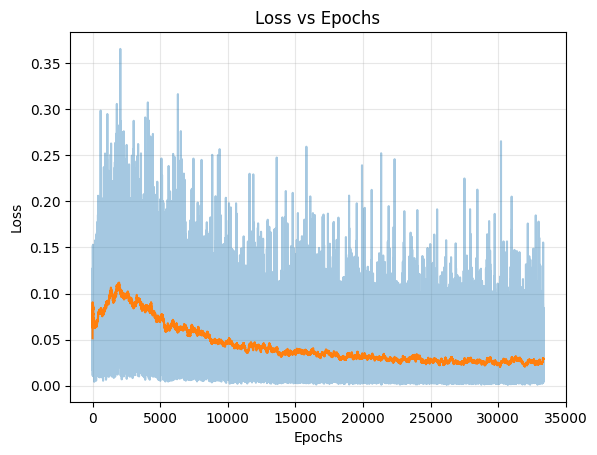

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(path + "D3QN/training/log_files/loss.csv")
# print(df)

ts_factor = 0.99

smooth = []
smooth.append(df.ewm(alpha=(1 - ts_factor)).mean())


plt.plot(df.iloc[:,1], alpha=0.4)
plt.plot(smooth[0].iloc[:,1])
plt.title("Loss vs Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(alpha=0.3)

plt.show()

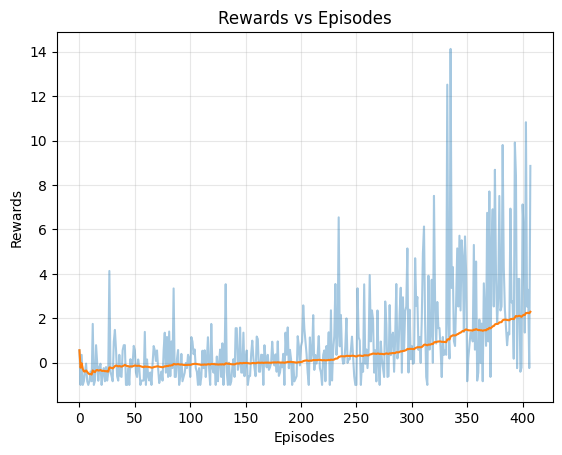

In [ ]:
df = pd.read_csv(path + "/D3DQN/training/log_files/reward.csv")
# print(df)

ts_factor = 0.99

smooth = []
smooth.append(df.ewm(alpha=(1 - ts_factor)).mean())


plt.plot(df.iloc[:,1], alpha=0.4)
plt.plot(smooth[0].iloc[:,1])
plt.title("Rewards vs Episodes")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.grid(alpha=0.3)

plt.show()

# Load the trained model and test it

In [ ]:
def load_model():
    latest_weights = tf.train.latest_checkpoint(save_dir)
    target_nn.load_weights(latest_weights)


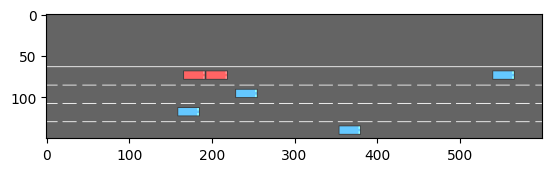

Episode reward was 17.733333333333338


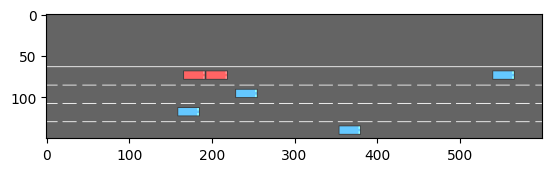

In [ ]:
env = gym.make('highway-v0')
state,_ = env.reset()
done = False
ep_rew = 0
load_model()
while not done:
  env.render()
  state = tf.expand_dims(state, axis=0)
  action = select_epsilon_greedy_action(state, epsilon=0.01)
  state, reward, done, truncated, info = env.step(action)
  frame = env.render()
  plt.imshow(frame)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())
  ep_rew += reward
print('Episode reward was {}'.format(ep_rew))
env.close()